# arXiv Monthly Downloads

### Caveats
Here are some caveats to consider, taken from the [arXiv website](https://arxiv.org).
> _While we have attempted to extract download data representing unique full-text downloads by real users, there are many factors which affect accuracy. These factors include:_
    >>1. _the data is from the main [arXiv site](https://arxiv.org) and the arXiv mirrors, though some mirror data is incomplete;_
    >>2. _only web downloads are included (and not FTP or email "downloads" that were formerly supported);_
    >>3. _we have counted downloads according to the COUNTER algorithm which excludes rapid repeat downloads;_
    >>4. _we have attempted to identify and remove robot or automated downloads from the count (false positives lead to undercounting, failing to identify robots leads to overcounting);_
    >>5. _data prior to 2009 has not been cleaned with as much care as later data, it shows trends nonetheless._

In [1]:
# Imports
from warnings import filterwarnings
filterwarnings('ignore')

# The usual suspects ...
import time_series as ts
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels

# And their accomplices ...
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

# Plotting settings
sns.set(context='notebook', style='whitegrid', palette='deep', rc=None)

In [2]:
# Data
downloads = pd.read_csv('get_monthly_downloads_extracted_09-08-2018.csv')

In [3]:
# Changing data types
ts.convert_to_datetime(data=downloads, column='month')

In [4]:
# Creating time-series object
downloads = ts.create_series(data=downloads, time_column='month', category_column='downloads')

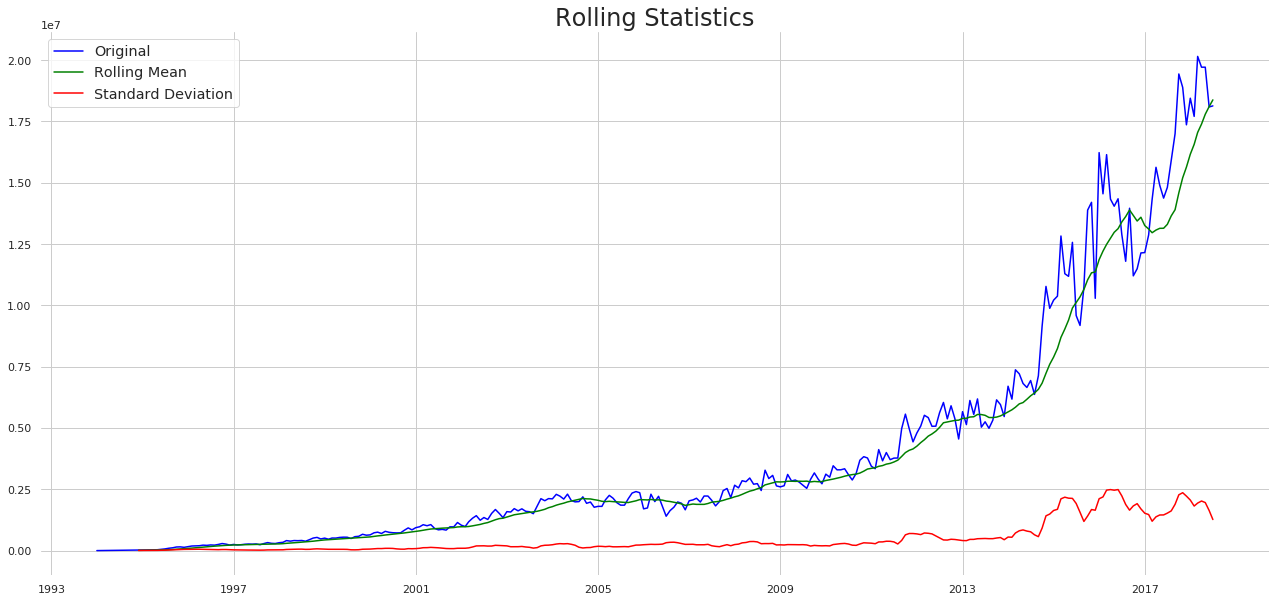

Results of Dickey-Fuller Test:
Test Statistic                   4.223103
p-value                          1.000000
Number of Lags Used             10.000000
Number of Observations Used    284.000000
Critical Value (1%)             -3.453587
Critical Value (5%)             -2.871771
Critical Value (10%)            -2.572222
dtype: float64


In [5]:
# Testing stationarity
ts.test_stationarity(downloads)

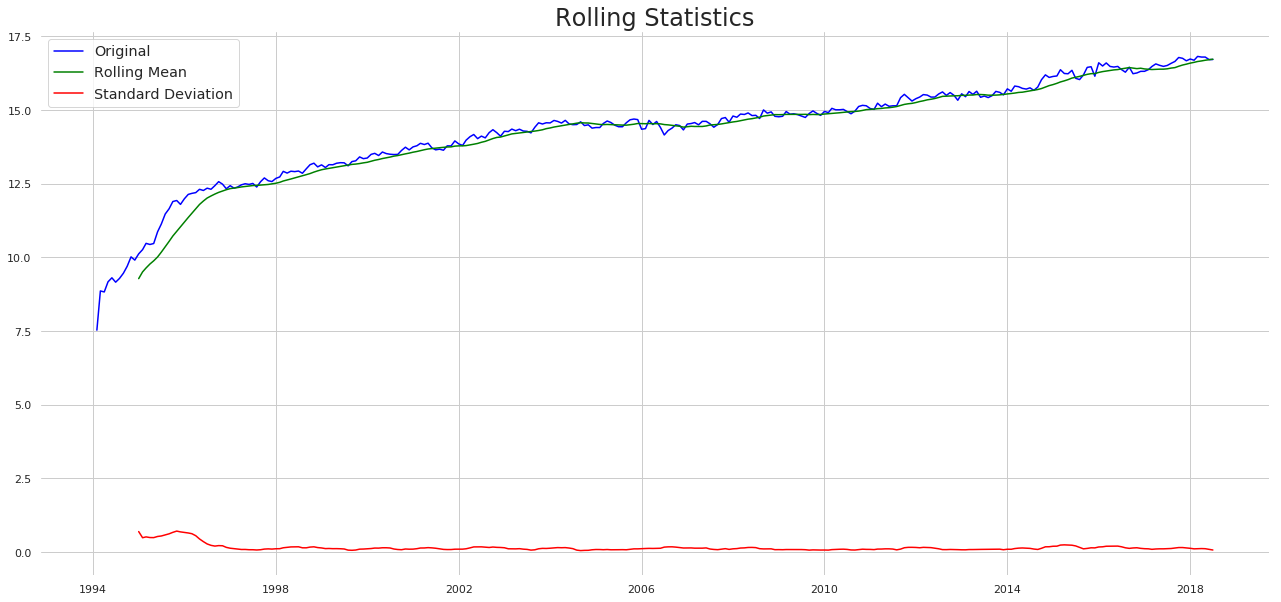

Results of Dickey-Fuller Test:
Test Statistic                  -2.012030
p-value                          0.281323
Number of Lags Used             12.000000
Number of Observations Used    281.000000
Critical Value (1%)             -3.453838
Critical Value (5%)             -2.871881
Critical Value (10%)            -2.572280
dtype: float64


In [6]:
# Reducing trend
downloads_log = np.log(downloads)
downloads_log.replace([np.inf, np.negative(np.inf)], np.nan, inplace=True)
downloads_log.dropna(inplace=True)

# Testing stationarity
ts.test_stationarity(downloads_log)

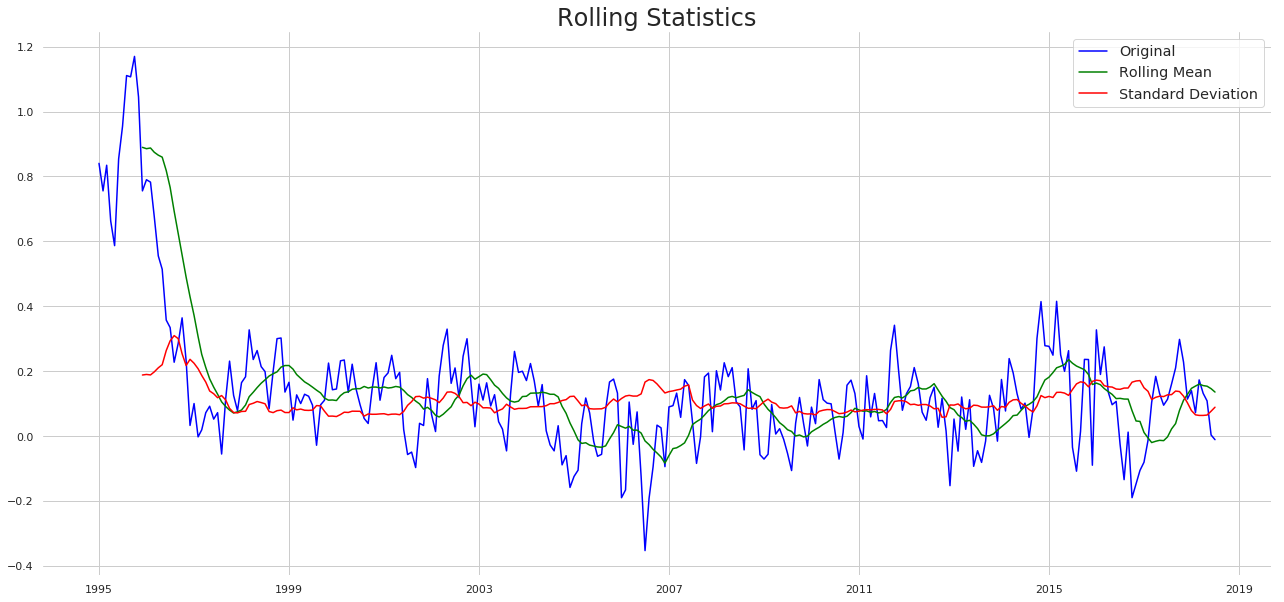

Results of Dickey-Fuller Test:
Test Statistic                -5.765412e+00
p-value                        5.547499e-07
Number of Lags Used            1.200000e+01
Number of Observations Used    2.700000e+02
Critical Value (1%)           -3.454804e+00
Critical Value (5%)           -2.872305e+00
Critical Value (10%)          -2.572506e+00
dtype: float64


In [7]:
# Removing rolling mean
downloads_log_rm = downloads_log.rolling(window=12, center=False).mean().dropna()
downloads_log_nrm = downloads_log - downloads_log_rm
downloads_log_nrm.dropna(inplace=True)

# Test stationarity
ts.test_stationarity(downloads_log_nrm)

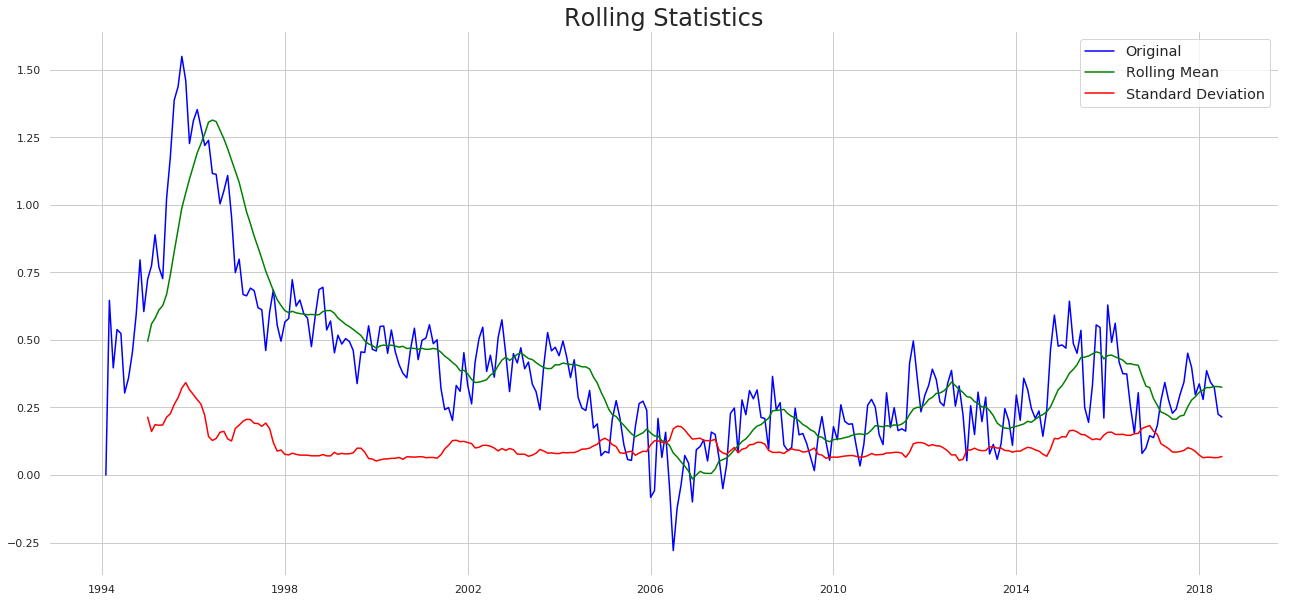

Results of Dickey-Fuller Test:
Test Statistic                  -2.555276
p-value                          0.102597
Number of Lags Used             12.000000
Number of Observations Used    281.000000
Critical Value (1%)             -3.453838
Critical Value (5%)             -2.871881
Critical Value (10%)            -2.572280
dtype: float64


In [8]:
# Removing exponentially weighted moving average
downloads_log_ewm = downloads_log.ewm(halflife=12).mean()
downloads_log_newm = downloads_log - downloads_log_ewm
downloads_log_newm.dropna(inplace=True)

# Test stationarity
ts.test_stationarity(downloads_log_newm)

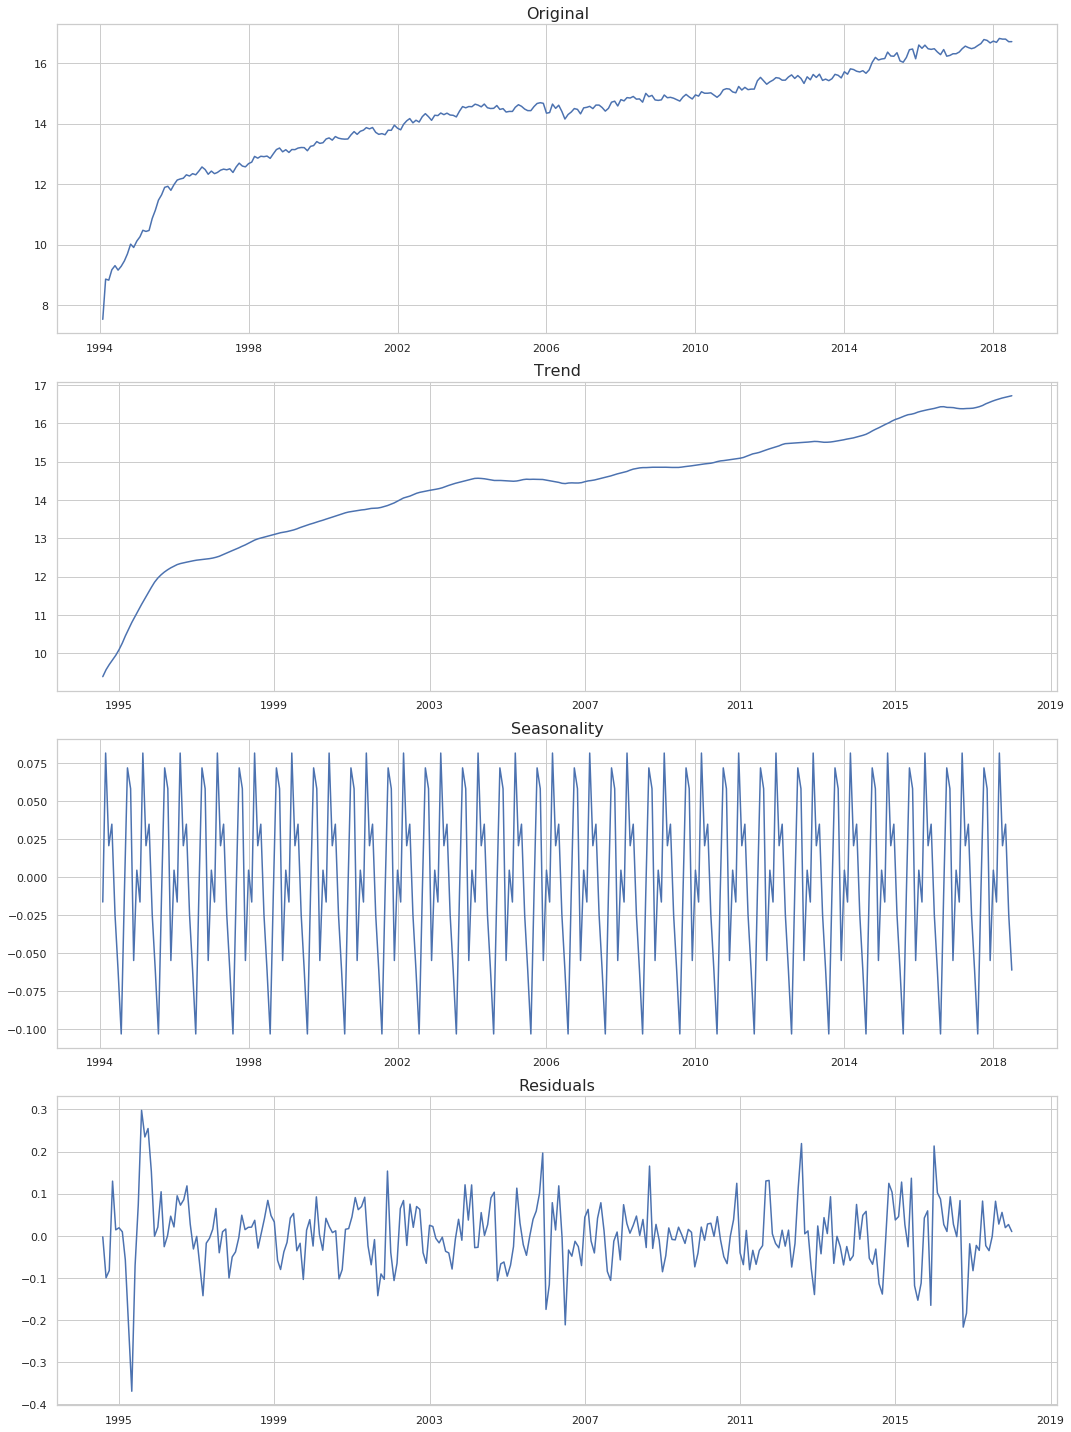

In [9]:
# Decomposing
seasonality, trend, residuals = ts.decompose(downloads_log)

# Plotting
ts.plot_decomposition(downloads_log, seasonality, trend, residuals)

In [10]:
# Differencing
downloads_log_ds = downloads_log - downloads_log.shift()
downloads_log_ds.dropna(inplace=True)

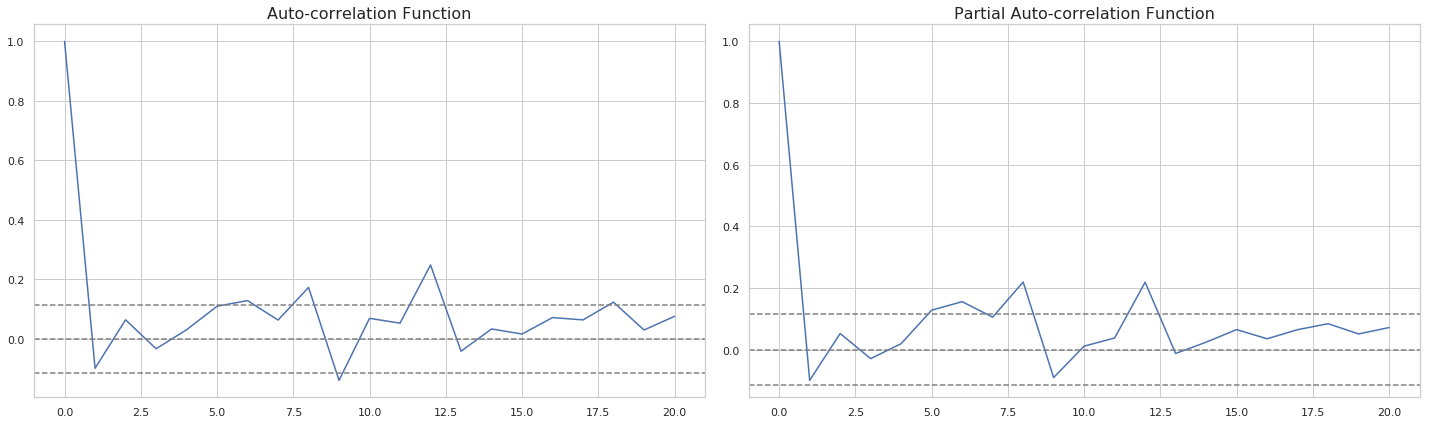

In [11]:
# ACF and PACF
lag_acf = acf(downloads_log_ds, nlags=20)
lag_pacf = pacf(downloads_log_ds, nlags=20, method='ols')

# Plotting
ts.plot_acf_and_pacf(time_series_data=downloads_log_ds, acf_data=lag_acf, pacf_data=lag_pacf)

In [12]:
# AR model
filterwarnings('ignore')
model_ar = ARIMA(downloads_log_ds, order=(1, 1, 0))
results_ar = model_ar.fit(desp=-1)
print(results_ar.summary())
print('RSS: {}'.format(sum(results_ar.resid ** 2)))

                             ARIMA Model Results                              
Dep. Variable:            D.downloads   No. Observations:                  292
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 114.687
Method:                       css-mle   S.D. of innovations              0.163
Date:                Sun, 03 Mar 2019   AIC                           -223.374
Time:                        22:35:55   BIC                           -212.344
Sample:                    04-01-1994   HQIC                          -218.955
                         - 07-01-2018                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0029      0.006     -0.488      0.626      -0.015       0.009
ar.L1.D.downloads    -0.6008      0.053    -11.281      0.000      -0.705      -0.496
                        

In [13]:
# MA model
filterwarnings('ignore')
model_ma = ARIMA(downloads_log_ds, order=(0, 1, 1))
results_ma = model_ma.fit(desp=-1)
print(results_ma.summary())
print('RSS: {}'.format(sum(results_ma.resid ** 2)))

                             ARIMA Model Results                              
Dep. Variable:            D.downloads   No. Observations:                  292
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 161.838
Method:                       css-mle   S.D. of innovations              0.138
Date:                Sun, 03 Mar 2019   AIC                           -317.675
Time:                        22:35:56   BIC                           -306.645
Sample:                    04-01-1994   HQIC                          -313.257
                         - 07-01-2018                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0006      0.000     -1.325      0.186      -0.001       0.000
ma.L1.D.downloads    -0.9506      0.020    -47.922      0.000      -0.990      -0.912
                        

In [14]:
# ARIMA model
filterwarnings('ignore')
model_arima = ARIMA(downloads_log_ds, order=(1, 1, 2))
results_arima = model_arima.fit(desp=-1)
print(results_arima.summary())
print('RSS: {}'.format(sum(results_arima.resid ** 2)))

                             ARIMA Model Results                              
Dep. Variable:            D.downloads   No. Observations:                  292
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 173.208
Method:                       css-mle   S.D. of innovations              0.133
Date:                Sun, 03 Mar 2019   AIC                           -336.416
Time:                        22:35:56   BIC                           -318.033
Sample:                    04-01-1994   HQIC                          -329.053
                         - 07-01-2018                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0007      0.001     -1.277      0.202      -0.002       0.000
ar.L1.D.downloads     0.4757      0.153      3.104      0.002       0.175       0.776
ma.L1.D.downloads    -1.